In [4]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf 
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES']='2'
%matplotlib inline

/home/lhw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lhw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
#根据给定的shape定义并初始化卷积核的权值变量
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

#根据shape初始化bias变量
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='VALID')
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
def save_model(saver,sess,save_path):
    path = saver.save(sess, save_path)
    print('model save in :{0}'.format(path))

In [6]:
def model(x, keep_prob):
    W_conv1 = weight_variable([3, 3, 1, 32])
    b_conv1 = bias_variable([32])

    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    W_conv2 = weight_variable([2, 2, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    W_conv3 = weight_variable([2, 2, 64, 128])
    b_conv3 = bias_variable([128])

    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)

    W_fc1 = weight_variable([11 * 11 * 128, 500])
    b_fc1 = bias_variable([500])

    h_pool3_flat = tf.reshape(h_pool3, [-1, 11 * 11 * 128])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

    W_fc2 = weight_variable([500, 500])
    b_fc2 = bias_variable([500])

    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
    h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

    W_fc3 = weight_variable([500, 30])
    b_fc3 = bias_variable([30])

    y_conv = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
    return y_conv

In [11]:
TRAIN_FILE = '../data/training.csv'
TEST_FILE = '../data/test.csv'
PIC_PATH = '../data/pic/'
SAVE_PATH = './model/model'
def input_data(test=False):
    file_name = TEST_FILE if test else TRAIN_FILE
    df = pd.read_csv(file_name)
    cols = df.columns[:-1]

    df = df.dropna()
    df['Image'] = df['Image'].apply(lambda img: np.fromstring(img, sep=' '))# / 255.0)

    X = np.vstack(df['Image'])
    X = X.reshape((-1, 96, 96, 1))

    if test:
        y = None
    else:
        y = df[cols].values #/ 96.0
    return X, y

#将文件中的数值转成图片并保存
def data2img(test=False):
    file_name = TEST_FILE if test else TRAIN_FILE
    df = pd.read_csv(file_name)
    df = df.dropna()
    df['Image'] = df['Image'].apply(lambda img: np.fromstring(img, sep=' '))

    X = np.vstack(df['Image'])
    for i in range(0, len(X)):
        data = np.reshape(X[i], (96, 96))
        new_im = Image.fromarray(data)
        #new_im.show()
        new_im = new_im.convert('RGB')
        new_im.save(PIC_PATH + str(i) + '.png', 'png')

In [8]:
data2img(test=True)

In [15]:
#数据读入
VALIDATION_SIZE = 100    #验证集大小
X,y = input_data()
X_valid, y_valid = X[:VALIDATION_SIZE], y[:VALIDATION_SIZE]
X_train, y_train = X[VALIDATION_SIZE:], y[VALIDATION_SIZE:]

In [21]:
EPOCHS = 500             #迭代次数
BATCH_SIZE = 64          #每个batch大小，稍微大一点的batch会更稳定
EARLY_STOP_PATIENCE = 50 #控制early stopping的参数



tf.reset_default_graph()
x = tf.placeholder("float", shape=[None, 96, 96, 1])
y_ = tf.placeholder("float", shape=[None, 30])
keep_prob = tf.placeholder("float")


#sess = tf.InteractiveSession()
y_conv = model(x, keep_prob)
rmse = tf.sqrt(tf.reduce_mean(tf.square(y_ - y_conv)))
train_step = tf.train.AdamOptimizer(1e-3).minimize(rmse)

#变量初始化



best_validation_loss = 1000000.0
current_epoch = 0
TRAIN_SIZE = X_train.shape[0]
#print(TRAIN_SIZE)
train_index = list(range(TRAIN_SIZE))
random.shuffle(train_index)
X_train, y_train = X_train[train_index], y_train[train_index]

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    print('begin training..., train dataset size:{0}'.format(TRAIN_SIZE))
    for i in range(EPOCHS):
        random.shuffle(train_index)  # 每个epoch都shuffle一下效果更好
        X_train, y_train = X_train[train_index], y_train[train_index]

        for j in range(0, TRAIN_SIZE, BATCH_SIZE):
            #print('epoch {0}, train {1} samples done...'.format(i, j))

            train_step.run(feed_dict={x: X_train[j:j + BATCH_SIZE],
                                      y_: y_train[j:j + BATCH_SIZE], keep_prob: 0.5})
            train_loss = rmse.eval(feed_dict={x: X_train[j:j + BATCH_SIZE],
                                      y_: y_train[j:j + BATCH_SIZE], keep_prob: 0.5})
        validation_loss = rmse.eval(feed_dict={x: X_valid, y_: y_valid, keep_prob: 1.0})

        print("epoch %d train loss is %f validataion loss is %f" % (i, train_loss, validation_loss))
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            current_epoch = i
            save_model(saver, sess, SAVE_PATH)  # 即时保存最好的结果
        elif (i - current_epoch) >= EARLY_STOP_PATIENCE:
            print('early stopping')
            break

begin training..., train dataset size:2040
epoch 0 train loss is 19.291246 validataion loss is 12.358980
model save in :./model/model
epoch 1 train loss is 15.225080 validataion loss is 10.437578
model save in :./model/model
epoch 2 train loss is 12.924103 validataion loss is 9.180266
model save in :./model/model
epoch 3 train loss is 11.909041 validataion loss is 7.510223
model save in :./model/model
epoch 4 train loss is 9.923268 validataion loss is 7.149246
model save in :./model/model
epoch 5 train loss is 10.927043 validataion loss is 7.982903
epoch 6 train loss is 11.183151 validataion loss is 8.260685
epoch 7 train loss is 10.031339 validataion loss is 6.901762
model save in :./model/model
epoch 8 train loss is 9.197521 validataion loss is 6.660061
model save in :./model/model
epoch 9 train loss is 8.108405 validataion loss is 6.133230
model save in :./model/model
epoch 10 train loss is 8.750210 validataion loss is 6.490628
epoch 11 train loss is 7.391893 validataion loss is 5.9

epoch 117 train loss is 4.427286 validataion loss is 2.493260
epoch 118 train loss is 4.558032 validataion loss is 2.703796
epoch 119 train loss is 4.181990 validataion loss is 2.642114
epoch 120 train loss is 4.588031 validataion loss is 2.541254
epoch 121 train loss is 4.053429 validataion loss is 2.443718
epoch 122 train loss is 5.057056 validataion loss is 2.438107
epoch 123 train loss is 4.486877 validataion loss is 2.381342
model save in :./model/model
epoch 124 train loss is 4.506027 validataion loss is 2.442994
epoch 125 train loss is 4.751729 validataion loss is 2.206644
model save in :./model/model
epoch 126 train loss is 4.742495 validataion loss is 2.236712
epoch 127 train loss is 4.891333 validataion loss is 3.526621
epoch 128 train loss is 4.738105 validataion loss is 2.244290
epoch 129 train loss is 4.083540 validataion loss is 2.213924
epoch 130 train loss is 4.702017 validataion loss is 2.229356
epoch 131 train loss is 4.684735 validataion loss is 2.168688
model save i

epoch 243 train loss is 4.266353 validataion loss is 2.107049
epoch 244 train loss is 4.029428 validataion loss is 1.889238
epoch 245 train loss is 3.706724 validataion loss is 1.706358
epoch 246 train loss is 3.775368 validataion loss is 1.699129
epoch 247 train loss is 4.059821 validataion loss is 1.702127
epoch 248 train loss is 3.469750 validataion loss is 2.059585
epoch 249 train loss is 4.337744 validataion loss is 1.973230
epoch 250 train loss is 4.055398 validataion loss is 1.811696
epoch 251 train loss is 3.532683 validataion loss is 1.997952
epoch 252 train loss is 4.244203 validataion loss is 1.876964
epoch 253 train loss is 4.185846 validataion loss is 1.861766
epoch 254 train loss is 3.516016 validataion loss is 1.692893
epoch 255 train loss is 4.158651 validataion loss is 1.990797
epoch 256 train loss is 3.724409 validataion loss is 2.392114
epoch 257 train loss is 3.992263 validataion loss is 2.137511
epoch 258 train loss is 4.185466 validataion loss is 1.794320
epoch 25

epoch 373 train loss is 3.969353 validataion loss is 1.780521
epoch 374 train loss is 3.668513 validataion loss is 1.565850
model save in :./model/model
epoch 375 train loss is 3.454929 validataion loss is 1.733144
epoch 376 train loss is 4.313652 validataion loss is 1.628118
epoch 377 train loss is 3.942122 validataion loss is 1.792386
epoch 378 train loss is 3.585748 validataion loss is 1.599322
epoch 379 train loss is 3.477854 validataion loss is 1.590351
epoch 380 train loss is 3.646736 validataion loss is 1.747237
epoch 381 train loss is 4.493082 validataion loss is 2.008400
epoch 382 train loss is 4.065072 validataion loss is 1.548316
model save in :./model/model
epoch 383 train loss is 3.909806 validataion loss is 1.737339
epoch 384 train loss is 3.479711 validataion loss is 1.536230
model save in :./model/model
epoch 385 train loss is 4.611838 validataion loss is 1.588120
epoch 386 train loss is 3.737388 validataion loss is 1.623910
epoch 387 train loss is 4.136891 validataion 

In [22]:
def show_pred(x, y_real, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax in axes:
        ax.imshow(x[0, ..., 0], 'gray')
        ax.axis('off')
    points_real = np.vstack(np.split(y_real[0], 15)).T 
    points_pred = np.vstack(np.split(y_pred[0], 15)).T 
    axes[0].plot(points_pred[0], points_pred[1], 'o', color='red')
    axes[0].set_title('Predictions', size=16)
    axes[1].plot(points_real[0], points_real[1], 'o', color='green')
    axes[1].plot(points_pred[0], points_pred[1], 'o', color='red', alpha=0.5)
    axes[1].set_title('Real', size=16)

INFO:tensorflow:Restoring parameters from ./model/model


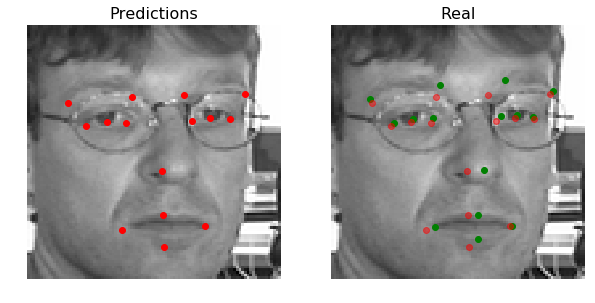

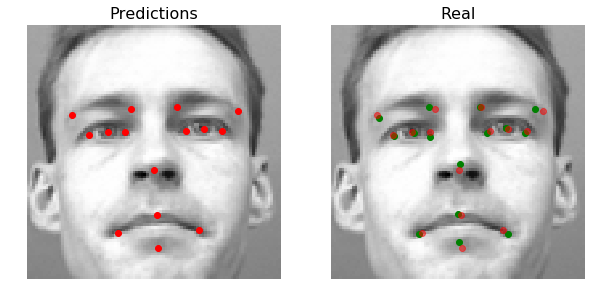

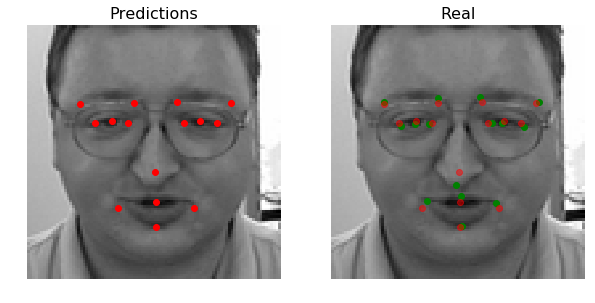

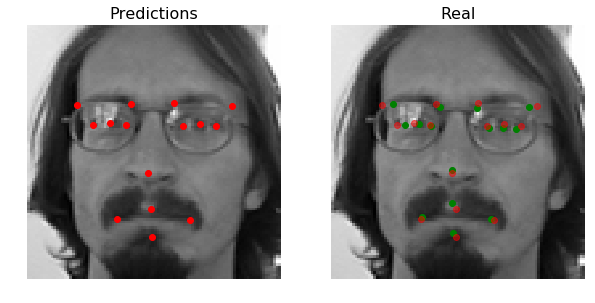

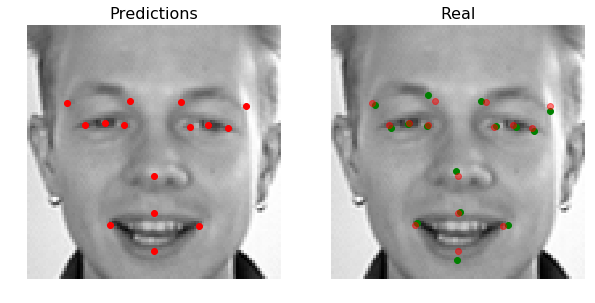

In [36]:
#测试
#print(X_valid.shape)
tf.reset_default_graph()
x_val_data = tf.placeholder("float", shape=[None, 96, 96, 1])
prob = tf.placeholder("float")
predict = model(x_val_data, prob)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, SAVE_PATH)
    for i in range(5):
        idx = np.random.choice(len(X_valid))
        sample_x = X_valid[idx, None]#增加一维(1, 96, 96, 1) 而x_val[0]=>( 96, 96, 1)
        sample_y = y_valid[idx, None]
        #sess.run(predict, feed_dict={x_val_data:sample_x, is_training:False})
        #validation_loss = rmse.eval(feed_dict={x: X_valid, y_: y_valid, keep_prob: 1.0})
        pred = predict.eval(feed_dict={x_val_data:sample_x, prob:1.0})
        show_pred(sample_x, sample_y, pred)

In [37]:
#提交结果
keypoint_index = {
    'left_eye_center_x':0,
    'left_eye_center_y':1,
    'right_eye_center_x':2,
    'right_eye_center_y':3,
    'left_eye_inner_corner_x':4,
    'left_eye_inner_corner_y':5,
    'left_eye_outer_corner_x':6,
    'left_eye_outer_corner_y':7,
    'right_eye_inner_corner_x':8,
    'right_eye_inner_corner_y':9,
    'right_eye_outer_corner_x':10,
    'right_eye_outer_corner_y':11,
    'left_eyebrow_inner_end_x':12,
    'left_eyebrow_inner_end_y':13,
    'left_eyebrow_outer_end_x':14,
    'left_eyebrow_outer_end_y':15,
    'right_eyebrow_inner_end_x':16,
    'right_eyebrow_inner_end_y':17,
    'right_eyebrow_outer_end_x':18,
    'right_eyebrow_outer_end_y':19,
    'nose_tip_x':20,
    'nose_tip_y':21,
    'mouth_left_corner_x':22,
    'mouth_left_corner_y':23,
    'mouth_right_corner_x':24,
    'mouth_right_corner_y':25,
    'mouth_center_top_lip_x':26,
    'mouth_center_top_lip_y':27,
    'mouth_center_bottom_lip_x':28,
    'mouth_center_bottom_lip_y':29
} 

In [38]:
#提交结果

#读取测试数据
test_img, _ = input_data(test=True)

tf.reset_default_graph()
x_test_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
prob = tf.placeholder("float")
predict = model(x_test_data, prob)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, SAVE_PATH)
    y_pred = []
    test_size = test_img.shape[0]
    batch_size = 1
    num_batch = test_size // batch_size
    remainder = test_size % batch_size
    print("数据分 %s 批， 前面每批数据 %s 个数据， 最后一批 %s 个数据" % (num_batch, batch_size, remainder))
    for i in range(num_batch):
        x_batch = test_img[i*batch_size : (i+1)*batch_size]
        #sess.run(predict, feed_dict={x_test_data:x_batch, is_training:False})
        y_pred_batch = predict.eval(feed_dict={x_test_data:x_batch, prob:1.0})
        y_pred.append(y_pred_batch)
    if remainder > 0:
        start_idx = num_batch * batch_size
        x_batch = test_img[start_idx : test_size-1]
        y_pred_batch = predict.eval(feed_dict={x_test_data:x_batch, prob:1.0})
        y_pred.append(y_pred_batch)
    print("predict test image done!")
    y_pred_np = np.array(y_pred)
    y = y_pred_np.reshape(-1, 30)
    #print(y.shape)
    output_file = open("submit.csv", 'w')
    output_file.write('RowId,location\n')
    id_lookup_table = open('../data/IdLookupTable.csv')
    id_lookup_table.readline()
    for line in id_lookup_table:
        RowId,ImageId,FeatureName = line.rstrip().split(',')
        image_index = int(ImageId) - 1
        feature_index = keypoint_index[FeatureName]
        feature_location = y[image_index][feature_index]
        output_file.write('{0},{1}\n'.format(RowId,feature_location))
    output_file.close()
    id_lookup_table.close()
    print('Finish!')

INFO:tensorflow:Restoring parameters from ./model/model
数据分 1783 批， 前面每批数据 1 个数据， 最后一批 0 个数据
predict test image done!
Finish!


In [48]:
#检查提交数据是否越界
def chack_submit(submit_path):
    df = pd.read_csv(submit_path)
    x = np.vstack(df['location'])
    for i in range(len(x)):
        if x[i] > 96:
            print('%d rows is invaild, the value is %f' % (i, x[i]))
    print('Finish')

In [50]:
SUBMIT_PATH = 'submit.csv'
chack_submit('submit_failed.csv')

7467 rows is invaild, the value is 96.010223
11457 rows is invaild, the value is 98.104500
14019 rows is invaild, the value is 96.955711
18863 rows is invaild, the value is 98.145561
19181 rows is invaild, the value is 101.885048
21235 rows is invaild, the value is 98.390572
21355 rows is invaild, the value is 104.567749
21483 rows is invaild, the value is 101.056313
22059 rows is invaild, the value is 97.671021
23451 rows is invaild, the value is 97.791336
23715 rows is invaild, the value is 102.878616
24531 rows is invaild, the value is 99.724388
25803 rows is invaild, the value is 97.490829
25931 rows is invaild, the value is 98.595284
27003 rows is invaild, the value is 99.932510
Finish
